# 最終的なモデル詰め合わせ

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# kNN
from sklearn.neighbors import KNeighborsClassifier

# NeuralNet, CNN
from torchvision import transforms
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(0)

# LightGBM
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# 画像読み込み
from pathlib import Path
import cv2

# 転移学習
from torchvision import models

In [2]:
# Path
dbPath = "../input/MATLABcsv/DCT15_NoCanny_DB.csv"
queryPath = "../input/MATLABcsv/DCT15_NoCanny_Query.csv"

In [3]:
# read data
db_df = pd.read_csv(dbPath)
query_df = pd.read_csv(queryPath)

In [4]:
db_df.head()

,target,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225
0,0,34237,2338.40,-2317.5,2399.2,672.120,-2021.00,-1246.60,-258.76,-221.120,...,202.44,-87.692,-188.46,-99.2230,72.304,-163.73,-16.076,65.983,-120.15,24.480
1,0,32604,1789.70,-2787.5,2564.3,474.050,-2557.60,-1059.40,-569.12,415.290,...,465.00,-110.290,-345.07,285.3400,-39.142,-158.30,90.198,-203.750,140.79,163.130
2,0,31548,-156.56,-3176.3,2628.3,-1169.900,-757.01,-826.06,-447.02,-450.540,...,323.55,220.410,283.35,4.0929,251.730,164.34,-174.380,37.233,-198.69,56.497
3,0,31641,1153.20,-3600.6,2560.9,-54.044,-1905.20,-605.09,-640.01,-361.980,...,698.24,149.770,-104.95,289.3700,13.461,172.84,90.500,-33.987,357.63,-108.630
4,0,39298,1499.90,-3133.1,3121.6,362.540,-2273.40,-735.98,-812.61,75.572,...,609.96,-432.450,-266.94,187.1800,-177.390,178.23,-120.470,-207.350,374.11,-208.330


In [5]:
query_df.head()

,target,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225
0,0,38572.0,-45.774,-2402.5,2486.8,-474.02,-1794.40,-1527.8000,-581.42,215.93,...,236.40,-202.47,-8.2586,72.497,177.9200,125.7300,-304.110,138.040,60.371,81.625
1,0,44169.0,1308.900,-1477.6,2715.1,1067.10,-2875.40,-2424.1000,-284.94,883.63,...,296.25,-302.78,-19.6590,-83.530,-149.4400,1.8622,132.830,-131.010,71.810,90.145
2,0,37983.0,3945.600,-4759.7,4886.7,799.35,533.45,-8.0552,-1397.90,-287.42,...,301.02,-247.76,-1.0817,-101.850,-5.9485,108.7500,-27.612,-161.330,-86.427,136.540
3,0,31090.0,2566.800,-2012.5,1603.9,-789.99,-622.81,-724.3800,-343.87,-326.26,...,151.61,-147.95,120.2100,288.030,111.7100,-123.6000,-23.432,-101.310,15.669,334.380
4,0,27192.0,3690.400,-3895.8,3051.8,-1289.90,-1397.40,-563.2800,-1106.90,481.08,...,-110.58,-161.42,-144.4300,380.620,-171.9300,-152.0500,-105.140,-51.232,119.030,10.244


In [6]:
db_feature_df = db_df.drop(["target"], axis=1).copy()
db_target_df = db_df["target"].copy()
query_featture_df =query_df.drop(["target"], axis=1).copy()
query_target_df = query_df["target"].copy()

In [7]:
def calc_accu(query_target_df, pred):
    correct_num = (prediction_df["target"] == prediction_df["predict"]).sum()
    accuracy = correct_num / prediction_df.shape[0]
    return correct_num, accuracy

# テーブルデータ
## 単純マッチング

In [8]:
"""
result = []
prediction_df = pd.DataFrame(query_target_df)
for i in range(query_featture_df.shape[0]):
    minimum_id = (db_feature_df - query_featture_df.iloc[i]).abs().sum(axis=1).idxmin()
    prediction_df.loc[i, "predict"] = db_target_df[minimum_id]
"""

'\nresult = []\nprediction_df = pd.DataFrame(query_target_df)\nfor i in range(query_featture_df.shape[0]):\n    minimum_id = (db_feature_df - query_featture_df.iloc[i]).abs().sum(axis=1).idxmin()\n    prediction_df.loc[i, "predict"] = db_target_df[minimum_id]\n'

In [9]:
result = []
prediction_df = pd.DataFrame(query_target_df)
for i in range(query_featture_df.shape[0]):
    minimum_id = (((db_feature_df - query_featture_df.iloc[i])**2).sum(axis=1)).idxmin()
    prediction_df.loc[i, "predict"] = db_target_df[minimum_id]

In [10]:
prediction_df.head()

,target,predict
0,0,0.0
1,0,1.0
2,0,18.0
3,0,17.0
4,0,7.0


In [11]:
correct_num = (prediction_df["target"] == prediction_df["predict"]).sum()
accuracy = correct_num / prediction_df.shape[0]

In [12]:
accuracy

0.5172413793103449

## kNN

In [13]:
DIV_NUM = 3 # k
DIST_SETTING = 2 # ユークリッド=2, マンハッタン=1

In [14]:
knn = KNeighborsClassifier(n_neighbors=DIV_NUM, p=DIST_SETTING, metric="minkowski")
knn.fit(db_feature_df.values, db_target_df.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [15]:
prediction = knn.predict(query_featture_df.values)
prediction_df = pd.DataFrame(query_target_df)
prediction_df["predict"] = prediction

In [16]:
correct_num = (prediction_df["target"] == prediction_df["predict"]).sum()
accuracy = correct_num / prediction_df.shape[0]

In [17]:
accuracy

0.4482758620689655

## NeuralNet

In [18]:
input_size = db_feature_df.shape[1]
# define network
net = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 20)
)

In [19]:
X_train = torch.tensor(db_feature_df.values, dtype=torch.float32)
y_train = torch.tensor(db_target_df.values, dtype=torch.int64)

X_test = torch.tensor(query_featture_df.values, dtype=torch.float32)
y_test = torch.tensor(query_target_df.values, dtype=torch.int64)

In [20]:
X_train.shape

torch.Size([200, 225])

In [21]:
X_test.shape

torch.Size([58, 225])

In [22]:
# 損失関数
loss_fn = nn.CrossEntropyLoss()
# adam
optimizer = optim.Adam(net.parameters())
# 損失ログ
losses_train = []
accuracy_test = []
accuracy_train = []
EPOCH = 600

In [23]:
# 20エポック回す
# ここだけ繰り返すと再学習しちゃうので注意
for epoc in range(EPOCH):
    optimizer.zero_grad()
    
    y_pred = net(X_train)
    
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    
    optimizer.step()
    
    losses_train.append(loss.item())
    
    _, predicted = torch.max(y_pred, 1)
    corrects_train = 0
    for i in range(len(predicted)):
        if(predicted[i]==y_train[i]):
            corrects_train += 1
    accuracy_train.append(corrects_train/len(y_train))
    
    y_test_pred = net(X_test)
    _, predicted = torch.max(y_test_pred, 1)
    corrects_test = 0
    for i in range(len(predicted)):
        if(predicted[i]==y_test[i]):
            corrects_test += 1
    accuracy_test.append(corrects_test/len(y_test))
    
    if(epoc%50 == 0 or epoc == (EPOCH-1)):
        print("-"*8+"epoch{}".format(epoc)+"-"*8)
        print("train accuracy:{:.3}".format(accuracy_train[-1]))
        print("train loss:{:.3}".format(losses_train[-1]))
        print("test accuracy:{:.3}".format(accuracy_test[-1]))
        print("-"*20)
print("max accuracy_test: {}".format(max(accuracy_test)))

--------epoch0--------
train accuracy:0.04
train loss:62.0
test accuracy:0.0517
--------------------
--------epoch50--------
train accuracy:1.0
train loss:0.000108
test accuracy:0.5
--------------------
--------epoch100--------
train accuracy:1.0
train loss:4.61e-06
test accuracy:0.5
--------------------
--------epoch150--------
train accuracy:1.0
train loss:1.59e-06
test accuracy:0.5
--------------------
--------epoch200--------
train accuracy:1.0
train loss:8.58e-07
test accuracy:0.5
--------------------
--------epoch250--------
train accuracy:1.0
train loss:5.53e-07
test accuracy:0.517
--------------------
--------epoch300--------
train accuracy:1.0
train loss:3.24e-07
test accuracy:0.534
--------------------
--------epoch350--------
train accuracy:1.0
train loss:2.88e-07
test accuracy:0.517
--------------------
--------epoch400--------
train accuracy:0.99
train loss:0.0244
test accuracy:0.241
--------------------
--------epoch450--------
train accuracy:1.0
train loss:1.19e-05
test 

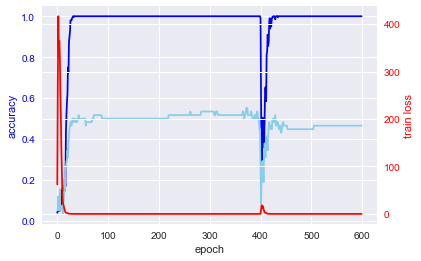

In [24]:
fig, ax1 = plt.subplots()
ax1.plot(list(range(EPOCH)), accuracy_train, color="blue")
ax1.plot(list(range(EPOCH)), accuracy_test, color="skyblue")
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(list(range(EPOCH)), losses_train, color="red")
ax2.set_ylabel("train loss", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.show()

## LightGBM

In [25]:
lgb_train = lgb.Dataset(db_feature_df.values, db_target_df.values)
lgb_eval = lgb.Dataset(query_featture_df.values, query_target_df.values, reference=lgb_train)

In [26]:
# LightGBM parameters
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': 20,
    'learning_rate': 0.1,
    'num_leaves': 15,
    'min_data_in_leaf': 10,
    'num_iteration': 200,
    'verbose': -1,
}

In [27]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
y_pred = gbm.predict(query_featture_df.values, num_iteration = gbm.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)


C:\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_error: 0.637931
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_error: 0.62069
[3]	valid_0's multi_error: 0.568966
[4]	valid_0's multi_error: 0.568966
[5]	valid_0's multi_error: 0.534483
[6]	valid_0's multi_error: 0.534483
[7]	valid_0's multi_error: 0.534483
[8]	valid_0's multi_error: 0.534483
[9]	valid_0's multi_error: 0.534483
[10]	valid_0's multi_error: 0.534483
[11]	valid_0's multi_error: 0.534483
[12]	valid_0's multi_error: 0.551724
[13]	valid_0's multi_error: 0.534483
[14]	valid_0's multi_error: 0.534483
[15]	valid_0's multi_error: 0.534483
[16]	valid_0's multi_error: 0.534483
[17]	valid_0's multi_error: 0.534483
[18]	valid_0's multi_error: 0.534483
[19]	valid_0's multi_error: 0.534483
[20]	valid_0's multi_error: 0.534483
[21]	valid_0's multi_error: 0.534483
[22]	valid_0's multi_error: 0.534483
[23]	valid_0's multi_error: 0.534483
[24]	valid_0's multi_error: 0.534483
[25]	valid_0's multi_error: 0.534483
[26]	valid_0's multi_e

In [28]:
accuracy_score(query_target_df, y_pred_max)

0.5

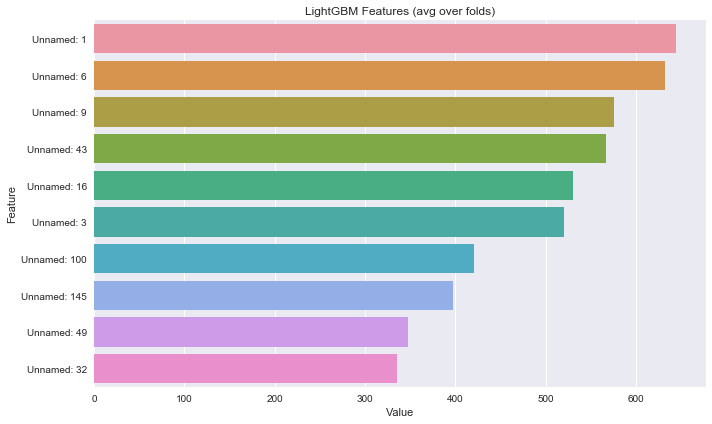

In [29]:
cols_to_fit = db_feature_df.columns.values
feature_importance = pd.DataFrame(sorted(
    zip(gbm.feature_importance(), cols_to_fit)), columns=['Value', 'Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(
    by="Value", ascending=False).head(10))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# 画像を直接入れる系
こっちのデータは**上のdafatrameと同じ順番**で入ってくると仮定してTargetは同じものを使う  
違う順で入れる場合は注意  

In [30]:
DB_IMG_PATH = "../input/Dlib/cutface/histFlattening/DB/jpeg/"
QUERY_IMG_PATH = "../input/Dlib/cutface/histFlattening/Query/jpeg/"

In [31]:
# 画像読み込み
p = Path(DB_IMG_PATH)
p = sorted(p.glob("*.jpg"))

dbImages = []
dbLabels = np.zeros(len(p), dtype=np.int)

for index, filename in enumerate(tqdm(p)):
    # 相対パスだと参照できなかったので絶対パスでやる
    img = cv2.imread(str(filename.resolve()), 0)
    # C, H, Wの形式にする(今回はグレースケールなのでC = 1)
    img = img.reshape([1, img.shape[0], img.shape[1]])
    dbImages.append((img/225).astype(np.float32))

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.23it/s]


In [32]:
# 画像読み込み
p = Path(QUERY_IMG_PATH)
p = sorted(p.glob("*.jpg"))

queryImages = []

for index, filename in enumerate(tqdm(p)):
    # 相対パスだと参照できなかったので絶対パスでやる
    img = cv2.imread(str(filename.resolve()), 0)
    # C, H, Wの形式にする(今回はグレースケールなのでC = 1)
    img = img.reshape([1, img.shape[0], img.shape[1]])
    queryImages.append((img/225).astype(np.float32))

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 113.83it/s]


In [33]:
dbImages[0].shape

(1, 128, 128)

## ピクセルマッチング

In [34]:
result = []
prediction_df = pd.DataFrame(query_target_df)
for queryIndex in range(len(queryImages)):
    distances = np.zeros(len(dbImages), dtype=np.float32)
    for dbIndex in range(len(dbImages)):
        distances[dbIndex] = (np.abs(dbImages[dbIndex] - queryImages[queryIndex])).sum()
    minimum_id = np.argmin(distances)
    prediction_df.loc[queryIndex, "predict"] = db_target_df[minimum_id]

In [35]:
correct_num = (prediction_df["target"] == prediction_df["predict"]).sum()
accuracy = correct_num / prediction_df.shape[0]

In [36]:
accuracy

0.46551724137931033

# CNN

In [37]:
X_dbToech = torch.Tensor(dbImages)
y_dbTorch = torch.LongTensor(db_target_df)
X_queryTorch = torch.Tensor(queryImages)
y_queryTorch = torch.LongTensor(query_target_df)

dbDataset = TensorDataset(X_dbToech, y_dbTorch)
queryDataset = TensorDataset(X_queryTorch, y_queryTorch)

batch_size = 8
dbLoader = DataLoader(dbDataset, batch_size=batch_size, shuffle=True)
queryLoader = DataLoader(queryDataset, batch_size=batch_size, shuffle=False)

In [38]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)
    
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.5),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.5),
    FlattenLayer()
)

test_input = torch.ones(1, 1, 128, 128)
conv_output_size = conv_net(test_input).size()[-1]

mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 20)
)

net = nn.Sequential(
    conv_net,
    mlp
)

In [39]:
# 評価ヘルパー
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    # ミニバッチ毎の結果をまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

# 訓練ヘルパー    
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_acc = 0
        for i, (xx, yy) in enumerate(tqdm(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        val_acc.append(eval_net(net, test_loader, device))
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
    print("max val acc: {}".format(max(val_acc)))

In [40]:
device_name = "cuda:0"

net.to(device_name)
train_net(net, dbLoader, queryLoader, n_iter=20, device=device_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.48it/s]


0 2.737286110719045 0.275 0.17241379618644714


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.20it/s]


1 2.222911089658737 0.47 0.3448275923728943


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.49it/s]


2 1.7134888420502346 0.65 0.43103447556495667


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.16it/s]


3 1.2021383866667747 0.875 0.5517241358757019


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.53it/s]


4 0.8293156487246355 0.94 0.5862069129943848


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.51it/s]


5 0.5218569003045559 0.98 0.568965494632721


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.66it/s]


6 0.3887925371527672 0.99 0.6206896305084229


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.19it/s]


7 0.3087601338823636 0.995 0.6379310488700867


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.53it/s]


8 0.19134925430019697 1.0 0.6551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.61it/s]


9 0.20069658880432448 0.99 0.6206896305084229


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.95it/s]


10 0.18046958247820535 0.99 0.6206896305084229


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.55it/s]


11 0.0933723896741867 1.0 0.6551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.85it/s]


12 0.0995476059615612 0.995 0.6551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.23it/s]


13 0.0722801002363364 1.0 0.6551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.42it/s]


14 0.08459442853927612 1.0 0.6206896305084229


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.47it/s]


15 0.08235378687580426 0.995 0.6379310488700867


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.54it/s]


16 0.08062489206592242 1.0 0.6551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.19it/s]


17 0.0688771903514862 1.0 0.6034482717514038


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.22it/s]


18 0.06189414362112681 0.995 0.6379310488700867


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.10it/s]


19 0.05671274413665136 0.99 0.6551724076271057
max val acc: 0.6551724076271057


# 転移学習
resnet18は入力が224\*224なのでresizeしてデータセットを作る

In [41]:
# 画像読み込み
p = Path(DB_IMG_PATH)
p = sorted(p.glob("*.jpg"))

dbImages_res = []

for index, filename in enumerate(tqdm(p)):
    # 相対パスだと参照できなかったので絶対パスでやる
    img = cv2.imread(str(filename.resolve()), 0)
    img = cv2.resize(img, (224, 224))
    # C, H, Wの形式にする(今回はグレースケールなのでC = 1)
    # img = img.reshape([1, img.shape[0], img.shape[1]])
    # C=1 なんだけど、resnet18 が3chで作ってあるので、全チャンネル一緒にしてやってみる
    img = np.array([img, img, img])
    
    dbImages_res.append((img/225).astype(np.float32))

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 225.98it/s]


In [42]:
# 画像読み込み
p = Path(QUERY_IMG_PATH)
p = sorted(p.glob("*.jpg"))

queryImages_res = []

for index, filename in enumerate(tqdm(p)):
    # 相対パスだと参照できなかったので絶対パスでやる
    img = cv2.imread(str(filename.resolve()), 0)
    img = cv2.resize(img, (224, 224))
    # C, H, Wの形式にする(今回はグレースケールなのでC = 1)
    # img = img.reshape([1, img.shape[0], img.shape[1]])
    # C=1 なんだけど、resnet18 が3chで作ってあるので、全チャンネル一緒にしてやってみる
    img = np.array([img, img, img])
    
    queryImages_res.append((img/225).astype(np.float32))

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 235.37it/s]


In [43]:
X_dbToech = torch.Tensor(dbImages_res)
y_dbTorch = torch.LongTensor(db_target_df)
X_queryTorch = torch.Tensor(queryImages_res)
y_queryTorch = torch.LongTensor(query_target_df)

dbDataset = TensorDataset(X_dbToech, y_dbTorch)
queryDataset = TensorDataset(X_queryTorch, y_queryTorch)

batch_size = 8
dbLoader = DataLoader(dbDataset, batch_size=batch_size, shuffle=True)
queryLoader = DataLoader(queryDataset, batch_size=batch_size, shuffle=False)

In [44]:
net = models.resnet18(pretrained=True)

for p in net.parameters():
    p.requires_grad = False
    
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

In [45]:
# 評価ヘルパー
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    # ミニバッチ毎の結果をまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

# 訓練ヘルパー    
def train_net(net, train_loader, test_loader, only_fc=True,
              optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    # 最後の層のみoptimizerに渡す
    if only_fc:
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
        
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_acc = 0
        for i, (xx, yy) in enumerate(tqdm(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        val_acc.append(eval_net(net, test_loader, device))
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)

In [46]:
device_name = "cuda:0"

net.to(device_name)
train_net(net, dbLoader, queryLoader, n_iter=20, device=device_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.93it/s]


0 0.2503377978379528 0.065 0.06896551698446274


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.64it/s]


1 0.22868154865379134 0.075 0.08620689809322357


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.96it/s]


2 0.18633087755491337 0.095 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.47it/s]


3 0.25577424094080925 0.095 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.21it/s]


4 0.22345643086979786 0.095 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.08it/s]


5 0.2837762690614909 0.085 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.15it/s]


6 0.2176682542388638 0.085 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.85it/s]


7 0.1997248901364704 0.095 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.32it/s]


8 0.16781945759430528 0.095 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.24it/s]


9 0.2865980288479477 0.09 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.99it/s]


10 0.26841791595021885 0.095 0.06896551698446274


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.05it/s]


11 0.23311263571182886 0.1 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.32it/s]


12 0.2468941050271193 0.1 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.86it/s]


13 0.24039817376372716 0.1 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.12it/s]


14 0.21526117351216575 0.1 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.67it/s]


15 0.18993592107047638 0.1 0.1551724076271057


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.15it/s]


16 0.19346693189193806 0.1 0.10344827175140381


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.93it/s]


17 0.23215410547951856 0.1 0.051724135875701904


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.12it/s]


18 0.20561975023398796 0.095 0.13793103396892548


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.32it/s]


19 0.22506666680177054 0.1 0.12068965286016464
